In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

In [2]:
ratings_df = pd.read_csv("/content/ratings.csv")
ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [3]:
print(ratings_df.shape)
print(ratings_df.user_id.nunique())
print(ratings_df.book_id.nunique())
ratings_df.isna().sum()

(981756, 3)
53424
10000


book_id    0
user_id    0
rating     0
dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (785404, 3)
Shape of test data: (196352, 3)


In [5]:
#Get the number of unique entities in books and users columns
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()

In [6]:
#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

In [7]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
_______________________________________________________________________________________

In [8]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/5
12272/12272 [==============================] - 136s 11ms/step - loss: 0.8605 - val_loss: 0.7126
Epoch 2/5
12272/12272 [==============================] - 141s 11ms/step - loss: 0.6854 - val_loss: 0.7033
Epoch 3/5
12272/12272 [==============================] - 139s 11ms/step - loss: 0.6528 - val_loss: 0.6938
Epoch 4/5
12272/12272 [==============================] - 143s 12ms/step - loss: 0.6221 - val_loss: 0.6991
Epoch 5/5
12272/12272 [==============================] - 143s 12ms/step - loss: 0.5918 - val_loss: 0.7061


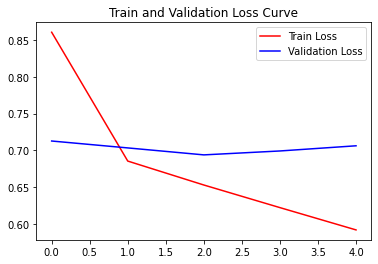

In [9]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [14]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
# load json and create model
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [18]:
b_id =list(ratings_df.book_id.unique())
b_id.remove(10000)

In [19]:
#Making recommendations for user 100
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])
pred = model.predict([book_arr, user])
pred

array([[4.316213 ],
       [4.478707 ],
       [3.2564762],
       ...,
       [4.577052 ],
       [4.273483 ],
       [3.4699705]], dtype=float32)

In [20]:
#Making recommendations for user 100
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])
pred = loaded_model.predict([book_arr, user])
pred

array([[4.316213 ],
       [4.478707 ],
       [3.2564762],
       ...,
       [4.577052 ],
       [4.273483 ],
       [3.4699705]], dtype=float32)

In [21]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:5]
pred_ids

array([8853, 9565, 7946, 5206, 5918])

In [22]:
books_df = pd.read_csv("/content/books.csv")
books_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,Links,Product URL,Unnamed: 25
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365.0,155254.0,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,NaN,NaN
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065.0,75867.0,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,https://i6.ztat.net/large/V1/02/1C/0T/QK/11/V1...,NaN,NaN
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824.0,95009.0,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,https://i6.ztat.net/large/TF/72/1C/01/5K/11/TF...,NaN,NaN
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896.0,72586.0,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,https://i2.ztat.net/large/VE/12/1C/14/9C/11/VE...,NaN,NaN
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745.0,51992.0,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,https://i6.ztat.net/large/S2/92/1C/0B/AK/11/S2...,NaN,NaN


In [23]:
books_df_copy = books_df.copy()
books_df_copy = books_df_copy.set_index("book_id")

In [27]:
books_df.iloc[pred_ids]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,Links,Product URL,Unnamed: 25
8853,8854,95602,95602,920037,6,842339523,9.780842e+12,Francine Rivers,1993.0,Mark of the Lion Trilogy,Mark of the Lion Trilogy,en-US,4.76,9081,9547.0,731.0,27,61,323,1363,7773,https://images.gr-assets.com/books/1349032180m...,https://images.gr-assets.com/books/1349032180s...,"https://assets.myntassets.com/dpr_2,q_60,w_210...",NaN,NaN
9565,9566,70487,70487,2244439,24,1417642165,9.781418e+12,Bill Watterson,1992.0,Attack of the Deranged Mutant Killer Monster S...,Attack of the Deranged Mutant Killer Monster S...,eng,4.72,9713,12197.0,233.0,15,30,514,2292,9346,https://images.gr-assets.com/books/1384735429m...,https://images.gr-assets.com/books/1384735429s...,"https://assets.myntassets.com/dpr_2,q_60,w_210...",NaN,NaN
7946,7947,5031805,5031805,40769318,96,1433502410,9.781434e+12,"Anonymous, Lane T. Dennis, Wayne A. Grudem",2002.0,NaN,ESV Study Bible,eng,4.76,8953,10784.0,262.0,98,90,367,1152,9077,https://images.gr-assets.com/books/1410151002m...,https://images.gr-assets.com/books/1410151002s...,https://i2.ztat.net/large/ML/92/1C/00/DQ/11/ML...,NaN,NaN
5206,5207,24818,24818,946589,28,836217357,9.780836e+12,Bill Watterson,1993.0,The Days Are Just Packed: A Calvin and Hobbes ...,The Days Are Just Packed: A Calvin and Hobbes ...,en-US,4.68,19143,20374.0,228.0,114,149,942,3636,15533,https://images.gr-assets.com/books/1418211162m...,https://images.gr-assets.com/books/1418211162s...,https://i1.ztat.net/large/PO/A2/1C/00/2Q/11/PO...,NaN,NaN
5918,5919,265205,265205,19119097,183,310919797,9.780311e+12,"Anonymous, Ronald A. Beers, Ronald A. Beers",1992.0,NaN,Life Application Study Bible: NIV,eng,4.67,13614,14774.0,270.0,239,207,670,1992,11666,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,https://i6.ztat.net/large/EV/42/1C/A5/VQ/12/EV...,NaN,NaN


In [28]:
web_book_data = books_df[["book_id", "Links"]]
web_book_data = web_book_data.sort_values('book_id')
web_book_data.head()

,book_id,Links
26,1,https://i1.ztat.net/large/GL/C2/1C/00/9T/11/GL...
20,2,https://i1.ztat.net/large/CV/72/1C/01/OJ/11/CV...
1,3,https://i6.ztat.net/large/V1/02/1C/0T/QK/11/V1...
17,5,https://i1.ztat.net/large/M3/22/1C/AB/DG/11/M3...
23,6,https://i1.ztat.net/large/IC/22/1C/05/OJ/11/IC...
